In [1]:
import sympy as sym
import scipy
import numpy as np
from scipy.interpolate import *
from scipy.integrate import *
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

In [2]:
# Step 1.1
def F(n):
    return 2*n*(n-1)*(n-1) + 2*n*n*(n-1)

In [3]:
F(1)

0

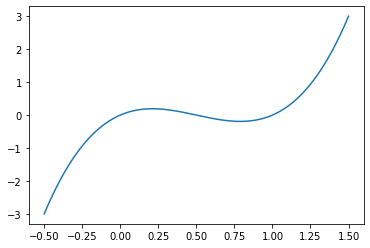

In [5]:
plt.plot(np.linspace(-0.5,1.5,1025), F(np.linspace(-0.5,1.5,1025)))

In [6]:
# Step 1.2
ndofs = 16

In [30]:
B = np.zeros((3,ndofs))
def compute_basis_func(ndofs, degree):
    # Insert here what was in notebook 9
    basis=[]
    q = np.linspace(0,1, ndofs)
    
    for i in range(ndofs):
        c = q * 0
        c[i]=1
        bi = PPoly.from_spline(splrep(q, c, k = degree))
       # B[:,i] = bi(i)
        basis.append(bi)
    return basis

In [31]:
q = np.linspace(0,1, ndofs)
compute_basis_func(ndofs,3)


In [32]:
print(ndofs)

16


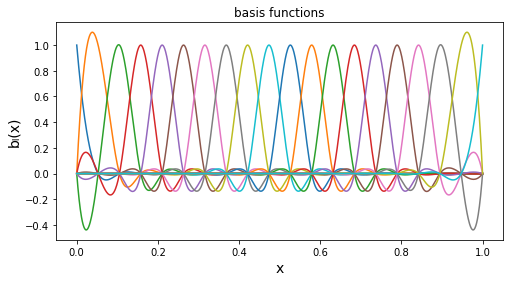

In [33]:
plt.figure(figsize = (8,4))
for i in range(20):
    _=plt.plot(np.linspace(0,1,1025), compute_basis_func(20,3)[i](np.linspace(0,1,1025)) )
    _ = plt.xlabel("x", fontsize = 14)
    _ = plt.ylabel("b\u2097(x)", fontsize = 14)
    _ = plt.title("basis functions")

In [34]:
# Step 1.3
def compute_global_quadrature(basis, n_gauss_quadrature_points):

    intervals = np.unique(basis[0].x)
    qp, w = np.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    qp = (qp+1)/2
    w /= 2

    h = np.diff(intervals)
    global_quadrature = np.array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = np.array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    return global_quadrature, global_weights

In [18]:
# Step 1.4
def compute_system_matrices(basis, global_quadrature, global_weights):
      
    dbasis = [bi.derivative(1) for bi in basis]
    
    Bq = np.array([basis[i](global_quadrature) for i in range(len(basis))]).T
    dBq = np.array([dbasis[i](global_quadrature) for i in range(len(basis))]).T
    
    # return M, K
    return np.einsum('qi, q, qj', Bq, global_weights, Bq), np.einsum('qi, q, qj', dBq, global_weights, dBq)

In [37]:
# Step 2.1

def solve_allen_cahan( eta_0_function , eps , dt , ndofs , degree ):
    
    q = np.linspace( 0 , 1 , ndofs )

    basis = compute_basis_func( ndofs, degree )
    
    global_quadrature, global_weights = compute_global_quadrature( basis , degree + 1 )
    
    M, K = compute_system_matrices( basis , global_quadrature , global_weights )
    
    T = 1.0  
    
    eta = np.zeros( ( int( T / dt ) + 1, ndofs ) )
    
    A = M + eps * eps * dt * K
    
    eta_now = eta_0_function( q )
    
    eta[ 0 , : ] = eta_now
    
    for i in range( 1 , int( T / dt ) + 1 ):
    
        b = M.dot( eta_now - dt * F( eta_now ) )
                   
        eta_later = np.linalg.solve( A, b )
                     
        eta[ i , : ] = eta_later
                   
        eta_now = eta_later
                   
    return eta, basis
